## Init Lib

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.ticker as mticker
from matplotlib.ticker import MaxNLocator
from transformers import AutoTokenizer, AutoModel
from pathlib import Path
import os
import sys
import polars as pl # used to read the .parquet files so its important
import numpy as np
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Add the parent directory (or specify path to 'utils' if it's higher)
dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..')) 
sys.path.append(dir)

from dataloader.NRMSdataloader import NRMSDataLoader
from models.nrms import NRMSModelPytorch
from eval.metricEval import MetricEvaluator, AucScore, MrrScore, NdcgScore

# Now you can import from utils
from utils import add_known_user_column, add_prediction_scores
from utils import get_transformers_word_embeddings, concat_str_columns,convert_text2encoding_with_transformers, create_article_id_to_value_mapping, create_article_id_to_value_mapping_list
from utils import get_script_directory, slice_join_dataframes, truncate_history,sampling_strategy_wu2019, create_binary_labels_column

In [2]:
import pandas as pd
import numpy as np

def decompose_datetime(datetime_str):
    # Convert to datetime object
    datetime_obj = pd.to_datetime(datetime_str)
    
    # Extract relevant features from the datetime object
    features = {
        'year': datetime_obj.year,
        'month': datetime_obj.month,
        'day': datetime_obj.day,
        'hour': datetime_obj.hour,
        'minute': datetime_obj.minute,
        'second': datetime_obj.second,
        'day_of_week': datetime_obj.weekday(),  # 0=Monday, 6=Sunday
        'is_weekend': 1 if datetime_obj.weekday() >= 5 else 0,
        'day_of_year': datetime_obj.dayofyear,
        'is_leap_year': 1 if (datetime_obj.year % 4 == 0 and (datetime_obj.year % 100 != 0 or datetime_obj.year % 400 == 0)) else 0
    }

    # Normalize certain features to [0, 1] range
    normalized_features = [
        features['year'] / 2024,  # Assuming year range of interest is up to 2023
        features['month'] / 12,
        features['day'] / 31,
        features['hour'] / 24,
        features['minute'] / 60,
        features['second'] / 60,
        features['day_of_week'] / 6,  # Normalize weekday to [0, 1]
        features['is_weekend'],  # Already binary
        features['day_of_year'] / 365,
        features['is_leap_year']
    ]
    
    return normalized_features

## Load Data

In [3]:
basic_path = get_script_directory()

DEFAULT_IS_BEYOND_ACCURACY_COL = "is_beyond_accuracy"


PATH = Path(basic_path+"/Data")
TRAIN_VAL_SPLIT = f"ebnerd_small"  # [ebnerd_demo, ebnerd_small, ebnerd_large]
TEST_SPLIT = f"ebnerd_testset"  # "ebnerd_testset", "ebnerd_testset_gt"

#_____________________Training____________________________
# Reads the behaviors file from training data
df_behaviors_train = df_behaviors = pl.scan_parquet(
    PATH.joinpath(TRAIN_VAL_SPLIT, "train", "behaviors.parquet")
)
# Reads the history file from training data
df_history_train = df_behaviors = pl.scan_parquet(
    PATH.joinpath(TRAIN_VAL_SPLIT, "train", "history.parquet")
)

#_____________________Validation____________________________
# Reads the behaviors file from Validation data
df_behaviors_val = df_behaviors = pl.scan_parquet(
    PATH.joinpath(TRAIN_VAL_SPLIT, "validation", "behaviors.parquet")
)
# Reads the History file from Validation data
df_history_val = df_behaviors = pl.scan_parquet(
    PATH.joinpath(TRAIN_VAL_SPLIT, "validation", "history.parquet")
)

#_____________________Test____________________________
# Reads the behaviors file from test data
df_behaviors_test = df_behaviors = (
    pl.scan_parquet(PATH.joinpath(TEST_SPLIT, "test", "behaviors.parquet"))
    .filter(~pl.col(DEFAULT_IS_BEYOND_ACCURACY_COL))
    .drop(DEFAULT_IS_BEYOND_ACCURACY_COL)
)
# Reads the History file from test data
df_history_test = df_behaviors = pl.scan_parquet(
    PATH.joinpath(TEST_SPLIT, "test", "history.parquet")
)

# ?? seem we already read this file ? but now without .drop(DEFAULT_IS_BEYOND_ACCURACY_COL)
df_behaviors_test_ba = df_behaviors = pl.scan_parquet(
    PATH.joinpath(TEST_SPLIT, "test", "behaviors.parquet")
).filter(pl.col(DEFAULT_IS_BEYOND_ACCURACY_COL))

#_____________________Reads Articles ??____________________________
df_articles = pl.scan_parquet(PATH.joinpath(TEST_SPLIT,"articles.parquet")).collect()

PLOT_PATH = Path("plot")

In [4]:
print(df_history_train.columns)

print(len(df_history_train.collect()))  
print(len(df_history_val.collect()))  
col_names_1 = df_history_val.collect().columns
print(col_names_1)
col_names_1 = df_history_train.collect().columns
print(col_names_1)

print(df_history_train.collect())

test = df_history_train.collect()['impression_time_fixed'][2]
print(test)



['user_id', 'impression_time_fixed', 'scroll_percentage_fixed', 'article_id_fixed', 'read_time_fixed']
15143
15342
['user_id', 'impression_time_fixed', 'scroll_percentage_fixed', 'article_id_fixed', 'read_time_fixed']
['user_id', 'impression_time_fixed', 'scroll_percentage_fixed', 'article_id_fixed', 'read_time_fixed']
shape: (15_143, 5)
┌─────────┬──────────────────────┬─────────────────────┬─────────────────────┬─────────────────────┐
│ user_id ┆ impression_time_fixe ┆ scroll_percentage_f ┆ article_id_fixed    ┆ read_time_fixed     │
│ ---     ┆ d                    ┆ ixed                ┆ ---                 ┆ ---                 │
│ u32     ┆ ---                  ┆ ---                 ┆ list[i32]           ┆ list[f32]           │
│         ┆ list[datetime[μs]]   ┆ list[f32]           ┆                     ┆                     │
╞═════════╪══════════════════════╪═════════════════════╪═════════════════════╪═════════════════════╡
│ 13538   ┆ [2023-04-27          ┆ [100.0, 35.0, …    

## Initialize Training and Validation split

In [5]:
def ebnerd_from_path(path: Path, history_size: int = 30) -> pl.DataFrame:
    """
    Load ebnerd - function
    """
    df_history = (
        pl.scan_parquet(path.joinpath("history.parquet"))
        .select("user_id", "article_id_fixed")
        .pipe(
            truncate_history,
            column="article_id_fixed",
            history_size=history_size,
            padding_value=0,
            enable_warning=False,
        )
    )
    df_behaviors = (
        pl.scan_parquet(path.joinpath("behaviors.parquet"))
        .collect()
        .pipe(
            slice_join_dataframes,
            df2=df_history.collect(),
            on="user_id",
            how="left",
        )
    )
    return df_behaviors

DATASPLIT = f"ebnerd_small"

COLUMNS = [
    "user_id",
    "article_id_fixed",
    "article_ids_inview",
    "article_ids_clicked",
    "read_time",
    "scroll_percentage",
    "impression_time",
    "impression_id",
]
HISTORY_SIZE = 20 # Size of the article title length to include? so any article that is longer is not included?
FRACTION = 0.01  # We only include 0.01% of the data? 

df_train = (
    ebnerd_from_path(PATH.joinpath(DATASPLIT, "train"), history_size=HISTORY_SIZE)
    .select(COLUMNS)
    .pipe(
        sampling_strategy_wu2019,
        npratio=4,
        shuffle=True,
        with_replacement=True,
        seed=123,
    )
    .pipe(create_binary_labels_column)
    .sample(fraction=FRACTION)
)
# =>
df_validation = (
    ebnerd_from_path(PATH.joinpath(DATASPLIT, "validation"), history_size=HISTORY_SIZE)
    .select(COLUMNS)
    .pipe(create_binary_labels_column)
    .sample(fraction=FRACTION)
)

df_articles = pl.read_parquet(PATH.joinpath(DATASPLIT,"articles.parquet"))
#df_articles.head(2)

In [6]:
print(df_train.columns)

print(df_train)

"""
article_ids = df_train['article_id_fixed'][5]
print(article_ids)
clicked = df_train['scroll_percentage'][5]
print(clicked)
impression = df_train['impression_time'][5]
print(impression)
label = df_train['labels'][5]
print(label)
"""

['user_id', 'article_id_fixed', 'article_ids_inview', 'article_ids_clicked', 'read_time', 'scroll_percentage', 'impression_time', 'impression_id', 'labels']
shape: (2_342, 9)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ user_id ┆ article_id ┆ article_i ┆ article_i ┆ … ┆ scroll_pe ┆ impressio ┆ impressio ┆ labels    │
│ ---     ┆ _fixed     ┆ ds_inview ┆ ds_clicke ┆   ┆ rcentage  ┆ n_time    ┆ n_id      ┆ ---       │
│ u32     ┆ ---        ┆ ---       ┆ d         ┆   ┆ ---       ┆ ---       ┆ ---       ┆ list[i8]  │
│         ┆ list[i32]  ┆ list[i64] ┆ ---       ┆   ┆ f32       ┆ datetime[ ┆ u32       ┆           │
│         ┆            ┆           ┆ list[i64] ┆   ┆           ┆ μs]       ┆           ┆           │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2127872 ┆ [9770741,  ┆ [9772710, ┆ [9773288] ┆ … ┆ null      ┆ 2023-05-2 ┆ 531257418 ┆ [0, 1, …  │
│         ┆ 97704

"\narticle_ids = df_train['article_id_fixed'][5]\nprint(article_ids)\nclicked = df_train['scroll_percentage'][5]\nprint(clicked)\nimpression = df_train['impression_time'][5]\nprint(impression)\nlabel = df_train['labels'][5]\nprint(label)\n"

## Tokenize data: 

In [7]:
TRANSFORMER_MODEL_NAME = "FacebookAI/xlm-roberta-base"
TEXT_COLUMNS_TO_USE = ["subtitle", "title"]
MAX_TITLE_LENGTH = 30
Test_col_to_use = ["published_time"]

# LOAD HUGGINGFACE:
transformer_model = AutoModel.from_pretrained(TRANSFORMER_MODEL_NAME)
transformer_tokenizer = AutoTokenizer.from_pretrained(TRANSFORMER_MODEL_NAME)

# We'll init the word embeddings using the
word2vec_embedding = get_transformers_word_embeddings(transformer_model)
#
df_articles, cat_cal = concat_str_columns(df_articles, columns=TEXT_COLUMNS_TO_USE)
df_articles, token_col_title = convert_text2encoding_with_transformers(
    df_articles, transformer_tokenizer, cat_cal, max_length=MAX_TITLE_LENGTH
)


# =>
article_mapping= create_article_id_to_value_mapping(
    df=df_articles, value_col=token_col_title
)

article_mapping_time= create_article_id_to_value_mapping(
    df=df_articles, value_col="published_time"
)





In [8]:
keys = article_mapping_time.keys()

test = article_mapping_time.get(3073151)
print(test)

print("")

keys = article_mapping.keys()
test = article_mapping_time.get(3073151)
print(test)


None

None


In [9]:
#print(type(article_mapping_time.get(3073151)))

#print(article_mapping)

lookup_matrix = np.array(list(article_mapping.values()))
print(type(lookup_matrix))

# MAKE LOOKUP MATRIX
lookup_matrix_2 = np.array(list(article_mapping_time.values()))
lookup_matrix_2 = np.array([[item] for item in lookup_matrix_2])
print(lookup_matrix_2)

UNKNOWN_ARRAY = np.zeros(lookup_matrix_2.shape[1], dtype=lookup_matrix_2.dtype)

<class 'numpy.ndarray'>
[[datetime.datetime(2006, 8, 31, 8, 6, 45)]
 [datetime.datetime(2006, 5, 21, 16, 57)]
 [datetime.datetime(2006, 5, 1, 14, 28, 40)]
 ...
 [datetime.datetime(2023, 6, 8, 6, 45, 46)]
 [datetime.datetime(2023, 6, 8, 6, 25, 42)]
 [datetime.datetime(2023, 6, 8, 6, 54, 53)]]


## Create Batch Dataset

In [10]:
train_dataloader = NRMSDataLoader(
    behaviors=df_train,
    article_dict=article_mapping,
    article_dict_2=article_mapping_time,
    unknown_representation="zeros",
    history_column="article_id_fixed",
    eval_mode=False,
    batch_size=32,
)



val_dataloader = NRMSDataLoader(
    behaviors=df_validation,
    article_dict=article_mapping,
    article_dict_2=article_mapping_time,
    unknown_representation="zeros",
    history_column="article_id_fixed",
    eval_mode=True,
    batch_size=32,
)

"""
Time_dataloader_train = NRMSDataLoader(
    behaviors=df_train,
    article_dict=article_mapping_test,
    unknown_representation="zeros",
    history_column="article_id_fixed",
    eval_mode=False,
    batch_size=32,
)

Time_dataloader_val = NRMSDataLoader(
    behaviors=df_validation,
    article_dict=article_mapping_test,
    unknown_representation="zeros",
    history_column="article_id_fixed",
    eval_mode=True,
    batch_size=32,
)
"""


'\nTime_dataloader_train = NRMSDataLoader(\n    behaviors=df_train,\n    article_dict=article_mapping_test,\n    unknown_representation="zeros",\n    history_column="article_id_fixed",\n    eval_mode=False,\n    batch_size=32,\n)\n\nTime_dataloader_val = NRMSDataLoader(\n    behaviors=df_validation,\n    article_dict=article_mapping_test,\n    unknown_representation="zeros",\n    history_column="article_id_fixed",\n    eval_mode=True,\n    batch_size=32,\n)\n'

In [18]:


(X1_train,X2_train), Y_train, (his_input_time_train,pred_input_time_train) = train_dataloader[0]

n_train_1 = 0
n_train_2 = 0
n_train_3 = 0
n_train_4 = 0
for (X1_train,X2_train), Y_train, (his_input_time_train,pred_input_time_train) in train_dataloader:
    n_train_1 += X1_train.shape[0]
    n_train_2 += X2_train.shape[0]

    n_train_3 += his_input_time_train.shape[0]
    n_train_4 += his_input_time_train.shape[0]

print("Training size: ", n_train_1)
print("Training size: ", n_train_2)
print("Training size: ", n_train_3)
print("Training size: ", n_train_4*10)


print("his train: ",X1_train.shape)
print("")

print("pred train: ",X2_train.shape)
print("")

print("y train: ",Y_train.shape)
print("")

print("his time train: ",his_input_time_train.shape)
print("")
print("pred time train: ", pred_input_time_train.shape)
print("")

(X1_val,X2_val), Y_val, (his_input_time_val,pred_input_time_val) = val_dataloader[0]

n_val_1 = 0
n_val_2 = 0
for (X1_val,X2_val), Y_val, (his_input_time_val,pred_input_time_val) in val_dataloader:
    n_val_1 += X1_val.shape[0]
    n_val_2 += X2_val.shape[0]

print("Training size: ", n_val_1)
print("Training size: ", n_val_2)

print("total: ", n_val_2+n_val_1+n_train_1+n_train_2 )

print("his val: ",X1_val.shape)
print("")

print("pred val: ",X2_val.shape)
print("")
print("y val ",Y_val.shape)
print("")
print("his time val: ",his_input_time_val.shape)
print("")
print("pred time val: ",pred_input_time_val.shape) 
print("")






Training size:  2342
Training size:  2342
Training size:  2342
Training size:  23420
his train:  (6, 20, 30)

pred train:  (6, 5, 30)

y train:  (6, 5)

his time train:  (6, 20, 1)

pred time train:  (6, 5, 1)

Training size:  29333
Training size:  29333
total:  63350
his val:  (169, 20, 30)

pred val:  (169, 1, 30)

y val  (169, 1)

his time val:  (169, 20, 1)

pred time val:  (169, 1, 1)



In [12]:
a = 145781+11713

print(a)

print(145781/a)
print(11713/a)

b = 145781+(11713*10)

print(b)

print(145781/b)
print((11713*10)/b)

157494
0.9256289128474735
0.07437108715252645
262911
0.5544880206609841
0.4455119793390159


In [13]:
from datetime import datetime
import torch

# Get the batch from the TensorFlow DataLoader
#(X1_train,X2_train), Y_train, (his_input_time_train,pred_input_time_train) = train_dataloader[3]

his_input_time_list = []
for (X1_train,X2_train), Y_train, (his_input_time_train,pred_input_time_train) in train_dataloader:
    
    for i in range(his_input_time_train.shape[0]):
        for j in range(his_input_time_train.shape[1]):
            if his_input_time_train[i,j,0] == 0:
                pass
            else:
                his_input_time_list.append(his_input_time_train[i,j,0])




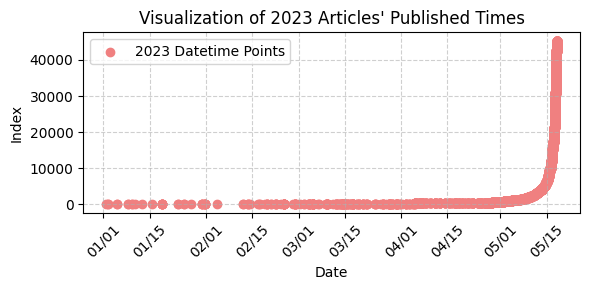

Number of datetimes before 2023: 445
total number of dates: 45830
percentage of dates from 2023 99.03 %


In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

def visualize_datetimes(datetime_list):
    # Filter the list for dates in 2023
    datetime_list = [dt for dt in datetime_list if dt.year == 2023]

    # Ensure the input list is sorted
    datetime_list = sorted(datetime_list)

    # Convert datetime to matplotlib date format
    dates = mdates.date2num(datetime_list)
    values = range(len(dates))  # Values for plotting (arbitrary, just for scatter points)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(6, 3))

    # Make the background transparent
    fig.patch.set_alpha(0.0)
    ax.patch.set_alpha(0.0)

    # Scatter plot the datetimes
    ax.scatter(datetime_list, values, color="lightcoral", label="2023 Datetime Points")

    # Formatting the x-axis for better readability
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    plt.xticks(rotation=45)  # Rotate x-axis labels

    # Labels and title
    ax.set_xlabel("Date")
    ax.set_ylabel("Index")
    ax.set_title("Visualization of 2023 Articles' Published Times")
    ax.legend()

    # Show grid for better visualization
    ax.grid(True, linestyle='--', alpha=0.6)

    # Display the plot
    plt.tight_layout()
    plt.show()




visualize_datetimes(his_input_time_list)

# Count datetimes before 2023
count_before_2023 = sum(dt < datetime(2023, 1, 1) for dt in his_input_time_list)
total = len(his_input_time_list)

print(f"Number of datetimes before 2023: {count_before_2023}")
print(f"total number of dates: {total}")
print("percentage of dates from 2023", np.round((1-(count_before_2023/total))*100,2),"%")


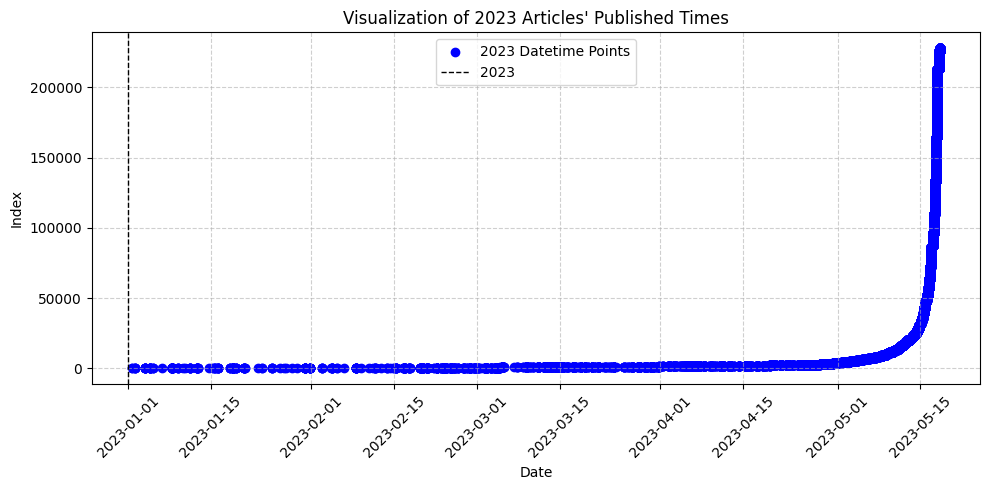

In [19]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

def visualize_datetimes(datetime_list):
    # Filter the list for dates in 2023
    datetime_list = [dt for dt in datetime_list if dt.year == 2023]

    # Ensure the input list is sorted
    datetime_list = sorted(datetime_list)

    # Convert datetime to matplotlib date format
    dates = mdates.date2num(datetime_list)
    values = range(len(dates))  # Values for plotting (arbitrary, just for scatter points)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 5))

    # Scatter plot the datetimes
    ax.scatter(datetime_list, values, color="blue", label="2023 Datetime Points")

    # Add a vertical black stippled line at 2023
    line_date = datetime(2023, 1, 1)
    ax.axvline(x=mdates.date2num(line_date), color="black", linestyle="--", linewidth=1, label="2023")

    # Formatting the x-axis for better readability
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)  # Rotate x-axis labels

    # Labels and title
    ax.set_xlabel("Date")
    ax.set_ylabel("Index")
    ax.set_title("Visualization of 2023 Articles' Published Times")
    ax.legend()

    # Show grid for better visualization
    ax.grid(True, linestyle='--', alpha=0.6)

    # Display the plot
    plt.tight_layout()
    plt.show()

# Example usage
visualize_datetimes(his_input_time_list)

## Create Embeddings: 

In [14]:

def datetime_to_embedding(datetime_array, embedding_size=400):
    """
    Converts an array of datetime objects and zeroes into embeddings of the specified size.
    
    Args:
        datetime_array (np.ndarray): Array of datetime.datetime objects and/or zeros.
        embedding_size (int): Size of the output embedding.
        
    Returns:
        np.ndarray: An array of shape (*input_shape, embedding_size).
    """
    # Ensure the input is a numpy array
    datetime_array = np.array(datetime_array, dtype=object)
    
    # Propagate the last valid datetime for any zero encountered
    def fill_zeros_with_previous(array):
        filled = []
        last_valid = None
        for item in array:
            if item == 0:
                filled.append(last_valid)
            else:
                filled.append(item)
                last_valid = item
        return np.array(filled, dtype=object)
    
    # Apply the zero-handling function to the entire array
    flat_array = datetime_array.ravel()
    filled_array = fill_zeros_with_previous(flat_array).reshape(datetime_array.shape)
    
    # Today's date
    today = datetime.now()
    
    # Compute time differences in seconds
    time_deltas = np.vectorize(
        lambda x: (x - today).total_seconds() if isinstance(x, datetime) else 0
    )(filled_array)

    print(time_deltas)
    
    # Normalize the time deltas (e.g., map to [0, 1])
    max_delta = np.max(np.abs(time_deltas)) if np.max(np.abs(time_deltas)) > 0 else 1
    normalized_deltas = time_deltas / max_delta  # Normalize to range [-1, 1]
    
    # Create embeddings
    shape = datetime_array.shape
    embeddings = np.random.rand(*shape, embedding_size) * normalized_deltas[..., None]
    
    return embeddings



def time_embedding_component(value, max_value, embedding_size):
    # Generate embedding for a given value using sine and cosine
    embedding = np.zeros(embedding_size)
    
    # Generate sine and cosine components
    for i in range(embedding_size // 2):
        embedding[2*i] = np.sin(value / (10000 ** (i / (embedding_size // 2))))
        embedding[2*i + 1] = np.cos(value / (10000 ** (i / (embedding_size // 2))))
    
    return embedding


# Compute the time embedding for a datetime
def compute_time_embedding(date_time, embedding_size=16):
    # Get the current date and time
    now = datetime(2024, 1, 1)
    
    # Compute the time difference in seconds
    time_difference = (now - date_time).total_seconds()

    # Normalize the time difference by a maximum value (e.g., seconds in a year)
    max_value = 365 * 24 * 60 * 60  # Seconds in a year
    normalized_value = time_difference / max_value
    
    # Ensure the normalized value is positive
    normalized_value = max(0, normalized_value)
    
    # Compute the time embedding
    embedding = time_embedding_component(normalized_value, max_value, embedding_size)
    
    return embedding


# Example usage
date_time_example = datetime(2023, 5, 1)
embedding = compute_time_embedding(date_time_example, embedding_size=400)

"""
# Create a sample list or tensor of shape (400,)
publish_time = datetime(2023, 11, 1)
time_embedding_early = compute_time_embedding(publish_time, embedding_size=400)
publish_time = datetime(2023, 1, 1)
time_embedding_late = compute_time_embedding(publish_time, embedding_size=400)
# Plot the data
plt.plot(time_embedding_early)
plt.title('Plot of Data with Shape (400,)')  # Title for the plot
plt.xlabel('Index')  # Label for the x-axis
plt.ylabel('Value')  # Label for the y-axis
plt.show()  # Display the plot

# Plot the data
plt.plot(time_embedding_late)
plt.title('Plot of Data with Shape (400,)')  # Title for the plot
plt.xlabel('Index')  # Label for the x-axis
plt.ylabel('Value')  # Label for the y-axis
plt.show()  # Display the plot
"""


(X1_train,X2_train), Y_train, (his_input_time_train,pred_input_time_train) = train_dataloader[0]

print("shape before: ")
print(his_input_time_train.shape)
print(pred_input_time_train.shape)

def compute_embedding_for_batch(his_input_time_train):

    n = his_input_time_train.shape[0]
    m = his_input_time_train.shape[1]
    time_embed_1 = torch.empty(n, m, 400)
    for i in range(n):
        for j in range(m):
            date = his_input_time_train[i,j,:]
            if date[0] == 0:
                date = [datetime(2023, 6, 1)]
            embedding = compute_time_embedding(date[0], embedding_size=400)
            time_embed_1[i,j,:] = torch.tensor(embedding)
    
    return time_embed_1


print("shape after: ")
his_input_time_train = compute_embedding_for_batch(his_input_time_train)
print(his_input_time_train.shape)
pred_input_time_train = compute_embedding_for_batch(pred_input_time_train)
print(pred_input_time_train.shape)


(X1_train,X2_train), Y_train, (his_input_time_train,pred_input_time_train) = val_dataloader[0]



print("shape before: ")
print(his_input_time_train.shape)
print(pred_input_time_train.shape)


print("shape after: ")
his_input_time_train = compute_embedding_for_batch(his_input_time_train)
print(his_input_time_train.shape)
pred_input_time_train = compute_embedding_for_batch(pred_input_time_train)
print(pred_input_time_train.shape)



shape before: 
(32, 20, 1)
(32, 5, 1)
shape after: 
torch.Size([32, 20, 400])
torch.Size([32, 5, 400])
shape before: 
(383, 20, 1)
(383, 1, 1)
shape after: 
torch.Size([383, 20, 400])
torch.Size([383, 1, 400])


In [15]:

"""
<MetricEvaluator class>: 
 {
    "auc": 0.534879696432761,
    "mrr": 0.32782427323318186,
    "ndcg@5": 0.3658238538873502,
    "ndcg@10": 0.4491365109952377
}
Overall Accuracy: 79.18%
0-Label Accuracy: 85.00%
1-Label Accuracy: 15.89%
Training of ebnerd_small has finished
"""

loss_tensorflow = [1.5978, 1.5080, 1.4251, 1.3674, 1.3400, 1.3108, 1.2789, 1.2617, 1.2406, 1.2338, 1.2151, 1.2001, 1.1948,
                   1.1875, 1.1689, 1.1617, 1.1510, 1.1327, 1.1214, 1.1011, 1.0670, 1.0424, 1.0216, 0.9922, 0.9698, 0.9165,
                   0.8976, 0.8620, 0.8377, 0.8121 ]

